<a href="https://colab.research.google.com/github/SigmaGQ/InsDetek.Insider_Threat_Detection_System/blob/main/Training_3.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from IPython.core.display import clear_output
#@title #__InsDetek__
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')
clear_output()
# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
# notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code' # WK
notebook_path = '/content/drive/MyDrive/Capstone/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM' # GQ
os.chdir(notebook_path);

In [30]:
#@title #__Requirements__
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
import re
from logging import raiseExceptions


import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from dataloader_ import df_to_tensor


# Data Preparation

In [8]:
class data_preparation():
    def __init__(self, path, idx = None):
        """
        Args:
            path(str): path of csv
            idx(str): index_col
        Object attributes:
            path, idx, df: input dataframe
            user_list, user_train, user_valid, user_test: list of user#
            train_df, valid_df, test_df: dataframe of splited users
            batch_size: batchsize for dataloader
            train, valid tet: dataloader for train, valid and test
        """
        self.path = path
        self.idx = idx
        
    def read_data(self):
        self.df = pd.read_csv(self.path, index_col = self.idx)
        if 'week' in self.df.columns:
            self.df = self.df.drop('week', axis = 1)
        self.feat_size = len(self.df.columns)-2
        self.num_class = self.df['insider'].unique().size
        print("====== Read Data ======\nread '{0}', shape = {1}\n".format(self.path, self.df.shape))
        return self

    def split(self, size):
        """split data into train, valid, test set
        Args:
            df(DataFrame): input dataframe (must includes column 'user')
            size(list): [train_size, valid_size, user_size]
        """
        assert (sum(size) == 1) & (len(size) == 3), "input of 'size' should be three values with a sum of 1"

        self.user_list = self.df['user'].unique()
        self.user_train, self.user_test = train_test_split(self.user_list, train_size = size[0], shuffle = True)
        self.user_valid, self.user_test = train_test_split(self.user_test, train_size = size[1]/(1-size[0]), shuffle = True)

        self.train_df = self.df[self.df['user'].isin(self.user_train)]
        self.valid_df = self.df[self.df['user'].isin(self.user_valid)]
        self.test_df = self.df[self.df['user'].isin(self.user_test)]

        print('====== Split Data ======\nsize = ', size)
        print('train: {0} - {1} users\n'.format(self.train_df.shape, len(self.user_train)),
            '\rvalid: {0} - {1} users\n'.format(self.valid_df.shape, len(self.user_valid)),
            '\rtest : {0} - {1} users\n'.format(self.test_df.shape, len(self.user_test)))
        return self

    def dataloader(self, batch_size, all_label = True, print_summary = True, shuffle = True):
        """convert df to dataloader
        Args:
            all_df (tuple or list): train, valid and test data.
            all_label (bool): output will be the labels of the whole sequence if True,
                or the label of the last datapoint in the sequence otherwise.
            print_summary (bool, optional): print the size of output.
            shuffle (bool): parameter 'shuffle' in dataloader
        """
        self.out_df = []
        self.batch_size = batch_size

        print("====== DataLoader ======")
        if len(self.train_df) != 0:
            print("[{0} Data]".format('Train'), end=' ')
            self.train = df_to_tensor(self.train_df, batch_size, all_label, print_summary, shuffle)
        if len(self.valid_df) != 0:
            print("[{0} Data]".format('Valid'), end=' ')
            self.valid = df_to_tensor(self.valid_df, batch_size, all_label, print_summary, shuffle)
        if len(self.test_df) != 0:
            print("[{0} Data]".format('Test'), end=' ')
            self.test = df_to_tensor(self.test_df, batch_size, all_label, print_summary, shuffle)


# Network

In [9]:
class LSTM_network(nn.Module):

    def __init__(self, input_size, num_class, batch_size):
        super(LSTM_network, self).__init__()
        self.conv1 = torch.nn.Conv1d(input_size, 256, kernel_size = 1) # [bs, f, seq] → [bs, 128, seq]
        # why not conv on feature dim
        self.conv2 = torch.nn.Conv1d(256, 128, kernel_size = 1) # [bs, f, seq] → [bs, 128, seq]
        self.lstm = nn.LSTM(128, 64, batch_first = True)
        self.hidden1 = nn.Linear(64, 32)
        self.hidden2 = nn.Linear(32, 8)
        self.hidden2tag = nn.Linear(8, num_class)


    def forward(self, input):
        self.input_seq = input.permute(0,2,1) # to [batchsize, feature, seq]
        self.cnn_out1 = self.conv1(self.input_seq)        
        self.cnn_out2 = self.conv2(self.cnn_out1)
        self.cnn_out2 = self.cnn_out2.permute(0,2,1) # to [batchsize, seq, feature]
        self.lstm_out, (self.hidden, self.cell) = self.lstm(self.cnn_out2)
        hidden1_out = self.hidden1(self.lstm_out)
        hidden2_out = self.hidden2(hidden1_out)
        logit = self.hidden2tag(hidden2_out)
        log_prob = F.log_softmax(logit, dim=2)
        return log_prob


#Evaluation

In [65]:
class Evaluation():
    def __init__(self, model, input_data: torch.utils.data.dataloader.DataLoader):
        """Return a list of clean(0)/insider(1) label, for each activities within the seq
        Args:
            model (nn.Module): model for prediction
            input_data (DataLoader): input_data, both feature and label, in dataloader
        """
        self.model = model
        self.dataset = input_data
    
    def __call__(self,  mode):
        """ set the value of logits: [log(prob_i)], predictions: y^, labels: y, avg_loss
        Args:
            mode (String): indicates which dataset to use, train, valid or test
        """
        if mode == 'train':
            self.data = self.dataset.train
        elif mode == 'valid':
            self.data = self.dataset.valid
        elif mode == 'test':
            self.data = self.dataset.test
        else:
            raise ValueError("mode should be 'train', 'valid' or 'test'") 

        with torch.no_grad(): # turns off automatic differentiation, which isn't required but helps save memory
            model.eval()

            self.log_prob, self.predictions, self.labels = [], [], []
            total_loss = 0
            for feature_seqs, label_seqs, mask_seqs in self.data:
                seq_len = feature_seqs.shape[1]
                mask_seqs = mask_seqs.bool()
                output_seqs = self.model(feature_seqs) # output_seqs.shape = [batchsize, seq_len, num_class]

                batch_loss_seqs = loss_function(output_seqs.reshape([-1,self.dataset.num_class,seq_len]), label_seqs) # loss.shape = [batchsize, seq_len] = [20,72]
                total_loss += torch.mul(batch_loss_seqs, mask_seqs).reshape(-1).sum() # add sum of loss within one batch 
                batch_loss = 0

                real_label_seqs = label_seqs[mask_seqs]
                real_output_seqs = output_seqs[mask_seqs] # real_output_seqs = [len(all real data within the batch)), num_class]
                pred_seqs = pd.DataFrame(real_output_seqs.tolist()).idxmax(axis=1) # pred_seqs = [len(all real data)]
                self.log_prob += real_output_seqs.tolist()
                self.predictions += pred_seqs.tolist()
                self.labels += real_label_seqs.tolist()

            model.train()

            self.avg_loss = total_loss / len(self.labels)

            return self


    def get_metrics(self, print_report = False):
        # self.recall_1 = recall_score(self.labels, self.predictions)
        # self.recall_0 = recall_score(self.labels, self.predictions, pos_label=0)
        self.precision, self.recall, self.fscore, self.support = precision_recall_fscore_support(self.labels, self.predictions, beta=2, zero_division = 0)
        if print_report:
            print(classification_report(self.labels, self.predictions, zero_division=0))

    # Compute ROC curve and ROC area for each class
    def roc_curve(self):
        if self.dataset.num_class != 2:
            print('ROC curve for multi-label not available')
            return
        else:
            y_prob = np.exp(np.array(eval.log_prob)[:,1])
            fpr, tpr, threshold = roc_curve(self.labels, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 8))
            plt.plot(fpr, 
                    tpr, 
                    color = 'darkorange',
                    lw = 2, 
                    label = 'ROC curve (area = %0.3f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
            plt.xlim([0.0, 1.00])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc = "lower right")
            plt.show()

    def pr_curve(self, y, prob):

        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y, prob)

        #create precision recall curve
        plt.figure(figsize=(10, 10))
        plt.plot(recall, precision, color='purple')

        #add axis labels to plot
        plt.title('Precision-Recall Curve')
        plt.ylabel('Precision')
        plt.xlabel('Recall')

        #display plot
        plt.show()

In [66]:
model = LSTM_network(input_size = data.feat_size, num_class = data.num_class, batch_size = data.batch_size)
eval = Evaluation(model, data)
eval('test').get_metrics(True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1382
           1       0.15      1.00      0.26       244

    accuracy                           0.15      1626
   macro avg       0.08      0.50      0.13      1626
weighted avg       0.02      0.15      0.04      1626



# Train

In [134]:
def train(model, epoch, dataset, optimizer, loss_function):
    epoch_bar = tqdm(range(epoch), leave = True)
    loss_list = []
    metric = []

    for epoch_i, epoch in enumerate(epoch_bar): 

        batch_bar = tqdm(dataset.train, leave = False)
        loss_list_epoch = []

        for batch_i, (feature_seqs, label_seqs, mask_seqs) in enumerate(batch_bar): # get feature sequenceS, label sequenceS and mask sequenceS
            
            # == Step 1. clear gradient ==
            model.zero_grad()
            # == Step 2. Run forward pass ==
            predict_seqs = model(feature_seqs)
            # == Step 3.1 Compute the loss ==
            seq_len = feature_seqs.shape[1] 
            predict_seqs = predict_seqs.reshape([-1,dataset.num_class,seq_len]) # [20,72,2]→[20,2,72] Because the input of NLLLoss is in (C,N_class, d1, d2, ...)
            loss = loss_function(predict_seqs, label_seqs) # loss.shape = [batchsize, seq_len] = [20,72]
            loss = torch.mul(loss, mask_seqs).reshape(-1)
            loss = loss.sum() / mask_seqs.sum()
            # == Step 3.2 Compute the gradients ==
            loss.backward()
            # == Step 3.3 Update the parameters ==
            optimizer.step()
            # batch_bar.set_description('batch: %i' % batch_i)
            # batch_bar.set_postfix(loss=format(loss,'.3f'))
            loss_list_epoch.append(loss)
        
        val = Evaluation(model, dataset)
        val('valid').get_metrics()
        metric.append(np.concatenate([[val.avg_loss],val.precision,val.recall,val.fscore]))
        loss_list.append(loss_list_epoch)

        torch.save({'model':model}, 'log/saved model/epoch{}.pth'.format(epoch_i))
        epoch_bar.set_description('Epoch: %i' % epoch)
        epoch_bar.set_postfix(valid_recall = '[0: {0:.3f}, 1: {1:.3f}]'.format(val.recall[0], val.recall[1])) 

    return loss_list, pd.DataFrame(metric, columns = ['avg_loss', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1'])

#\_\_main__

In [13]:
data_path = 'data/data_3.1.csv'
split_size = [0.8, 0.1, 0.1]
batchsize = 32
data = data_preparation(data_path, 'idx')
# data = data_preparation(data_path)
data.read_data().split(split_size).dataloader(batchsize)

====== Read Data ======
read 'data/data_3.1.csv', shape = (19381, 405)

====== Split Data ======
size =  [0.8, 0.1, 0.1]
train: (15519, 405) - 614 users
valid: (1928, 405) - 77 users
test : (1934, 405) - 77 users

====== DataLoader ======
[Train Data] Input DataFrame: (15519, 405) with 14.89% insiders
   => 614 sequences (users)
       features: [43, 403], labels: [43] in size of [(max) length, dimension]
   => 19 batches in Dataloader (batchsize = 32)
       features: [32, 48, 403], labels: [32, 45], masks: [32, 49] in size of [batchsize, (max) length, dimension]

[Valid Data] Input DataFrame: (1928, 405) with 14.83% insiders
   => 77 sequences (users)
       features: [49, 403], labels: [49] in size of [(max) length, dimension]
   => 2 batches in Dataloader (batchsize = 32)
       features: [32, 49, 403], labels: [32, 38], masks: [32, 47] in size of [batchsize, (max) length, dimension]

[Test Data] Input DataFrame: (1934, 405) with 15.77% insiders
   => 77 sequences (users)
       fe

In [ ]:
model = LSTM_network(input_size = data.feat_size, num_class = data.num_class, batch_size = data.batch_size)
weight = torch.tensor([1., 10.])
loss_function = nn.NLLLoss(weight, reduction = 'none') # 'none' to get list of loss
    # NLLLoss takes list of num_class-D logits: [log(prob_class_i)] as input, 
    # and avg&sum the true logits (i.e. takes the log(prob_2) when label=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs_num = 150
loss_list, metric_df = train(model, epochs_num, data, optimizer, loss_function)
# loss_list_sf, valid_loss_list_sf, recall_list_sf = train(model, epochs_num, train_data, optimizer, loss_function)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
fepoch_loss = []
loss_df = pd.DataFrame(columns = ['epoch', 'batch', 'loss'])
for i, epoch_i_loss in enumerate(loss_list):
    epoch_loss = []
    # print(epoch_i_loss)
    for batch_j_loss in epoch_i_loss:
        epoch_loss.append(float(batch_j_loss.detach().numpy()))
    df_temp = pd.DataFrame(columns = ['epoch', 'batch', 'loss'])
    df_temp['batch'] = list(range(len(epoch_i_loss)))
    df_temp['epoch'] = float(i)    
    df_temp['epoch'] = df_temp['epoch'].astype(float)
    # print(df_temp)
    df_temp['loss'] = epoch_loss
    loss_df = loss_df.append(df_temp)
loss_df = loss_df.reset_index(drop=True)

In [ ]:
#@title Loss of each epoch
color_list = ['rgb({0}, {0}, {0})'.format(int(i/epochs_num*255)) for i in range(epochs_num)]
# fig = px.line(loss_df[loss_df['epoch']%10 == 0], x = 'batch', y = 'loss', color = 'epoch', color_discrete_sequence= color_list)
fig = px.line(loss_df, x = 'batch', y = 'loss', color = 'epoch', color_discrete_sequence= color_list)
fig.update_layout(plot_bgcolor='#a1afc9')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
fig = px.line(loss_df, y = 'loss', color = 'epoch', color_discrete_sequence= color_list)
fig.update_layout(plot_bgcolor='#a1afc9')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# #@title Train & Valid Loss
# train_valid_loss = loss_df.groupby('epoch').mean().reset_index()
# train_valid_loss['valid'] = 0

# valid_loss = pd.DataFrame(columns = ['loss', 'valid'])
# valid_loss['loss'] = valid_loss_list
# valid_loss['loss'] = valid_loss['loss'].astype(float)
# valid_loss['valid'] = 1
# valid_loss = valid_loss.reset_index()
# valid_loss = valid_loss.rename(columns={'index':'epoch'})
# train_valid_loss = train_valid_loss.append(valid_loss)
# px.line(train_valid_loss, x = 'epoch', y = 'loss', color = 'valid')

train_valid_loss = loss_df.groupby('epoch').mean().reset_index()
train_valid_loss['valid'] = 0

valid_loss = pd.DataFrame(columns = ['loss', 'valid'])
valid_loss['loss'] = metric_df['avg_loss']
valid_loss['loss'] = valid_loss['loss'].astype(float)
valid_loss['valid'] = 1
valid_loss = valid_loss.reset_index()
valid_loss = valid_loss.rename(columns={'index':'epoch'})
train_valid_loss = train_valid_loss.append(valid_loss)
px.line(train_valid_loss, x = 'epoch', y = 'loss', color = 'valid')

In [ ]:
# # @title Validation Recall
# recall_df = pd.DataFrame(recall_list, columns = ['recall of 0', 'recall of 1']).melt().reset_index()
# recall_df['index'] = recall_df['index'].map(lambda x: x % epochs_num)
# recall_df = recall_df.rename(columns={'index':'epoch', 'variable':'label', 'value':'recall'})
# px.line(recall_df, x = 'epoch', y = 'recall', color = 'label')

# @title Validation Recall
recall_df = metric_df[['recall_0', 'recall_1']].melt().reset_index().rename(columns={'recall_0':'recall of 0 (clean)', 'recall_1':'recall of 1(malicious)'})
recall_df['index'] = recall_df['index'].map(lambda x: x % epochs_num)
recall_df = recall_df.rename(columns={'index':'epoch', 'variable':'label', 'value':'recall'})
px.line(recall_df, x = 'epoch', y = 'recall', color = 'label')

In [ ]:
#@title Precision-Recall by epochs
px.scatter(metric_df, x='recall_1', y='recall_0')

NameError: ignored

In [ ]:
recall_df

In [ ]:
recall_df = pd.DataFrame(recall_list, columns = ['recall of 0', 'recall of 1']).melt().reset_index()
recall_df['index'] = recall_df['index'].map(lambda x: x % epochs_num)
recall_df['data'] = 'data'
recall_df = recall_df.rename(columns={'index':'epoch', 'variable':'label', 'value':'recall'})
recall_df

In [ ]:
recall_df_sf = pd.DataFrame(recall_list_sf, columns = ['recall of 0', 'recall of 1']).melt().reset_index()
recall_df_sf['index'] = recall_df_sf['index'].map(lambda x: x % epochs_num)
recall_df_sf['data'] = 'shuffled data'
recall_df_sf = recall_df_sf.rename(columns={'index':'epoch', 'variable':'label', 'value':'recall'})
recall_df_sf

In [ ]:
recall_all = recall_df.append(recall_df_sf)
px.line(recall_all, x = 'epoch', y = 'recall', color = 'label', line_dash = 'data')

In [ ]:
test_model = Predictor(model, test_data)
test_pred, test_true = test_model.predictor()
test_model.get_metrics(True)

In [ ]:
loss_list[21].grad

In [ ]:
temp = []
loss_df = pd.Series(loss_list)
for i in range(100):
    temp.append(loss_list.iloc[:,20*60+i])
loss_plot(temp, False)

# Search - loss weight

In [ ]:
weight_list = torch.tensor([[1.5, 5], [1.5,6], [1,6], [0.1,0.9],[0.01,0.99]])
for weight in weight_list:
    print('=== ',weight,' ===')
    loss_function = nn.NLLLoss(weight, reduction = 'none') 
    loss_list = train(model, data_loader, optimizer, loss_function)
    _ = loss_plot(loss_list, False)
    predictor = Predictor(model, df)
    predictor.get_metrics()

# Results

In [ ]:
# # to change default colormap
# plt.rcParams["image.cmap"] = "Set1"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

In [ ]:
def write_log(exp_n, comment):
    exp = str(exp_n).zfill(3)
    path = 'log/exp' + exp + '/'
    if os.path.exists(path):
        print("=== Overwriting!!! ===")
    else:
        os.makedirs(path)   

    with open("log/log.txt","a") as f:
        f.write('\r\n\r\n' + exp)
        f.write('\r\n\t' + comment)

    dic = {'model':model, 'optim':optimizer}
    torch.save(dic, path +'model_optim.pth')

    print(path)
    return path


In [ ]:
info =  '==== model info ====\n'\
        + 'batchsize=' + str(batch_size)\
        + '\n' + 'optim=' + optimizer.__class__.__name__\
        + '(lr={:g})'.format(optimizer.param_groups[0]['lr'])
print(info)
comment = """
data3.1.csv
100 epochs lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2
""" + info

In [ ]:
exp_nums = re.findall('\d{3}', str(os.listdir('log')))
exp_new = max(list(map(lambda x: int(x), exp_nums))) + 1

In [ ]:
path = write_log(exp_new, comment)

## Loss

In [ ]:
def loss_plot(loss_list, save=True):
    losslist = []
    for i in loss_list:
        losslist.append(float(i.detach().numpy()))
    note = '\n $\mathbf{data3.2, cov-cov-lstm-}$'
    plt.figure(figsize = (10,5))
    plt.suptitle(note + re.findall('LSTMTagger\(\\n(.+)\\n\)$',str(model), re.S)[0], y = -0.001)
    plt.subplot(1,2,1)
    plt.plot(losslist)
    plt.subplot(1,2,2)
    plt.plot(losslist)
    plt.ylim(0,5)
    if save:
        plt.savefig(path + 'loss.jpg', bbox_inches='tight')
    return losslist
# losslist = loss_plot(loss_list)

In [ ]:
loss_df = pd.DataFrame(losslist)#.reset_index(drop=False)
loss_df.columns = ['loss']#['epoch', 'loss']
loss_df.to_csv(path+'loss.csv', index = False)

In [ ]:
# save
# torch.save(dic, path +'model_optim.pth')
# load
# net = torch.load('.pth')
# net['model'].state_dict()

# log

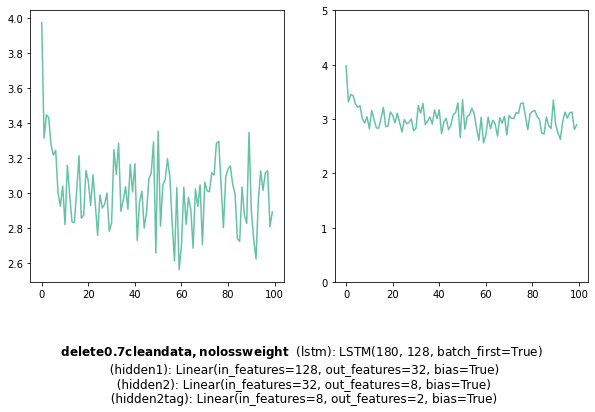

0.9, 0.1
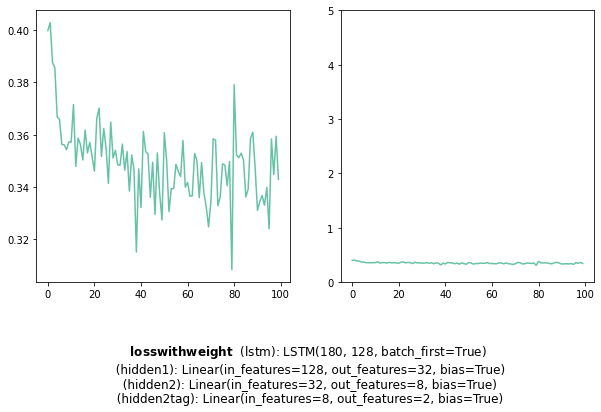

## ep - bc=32

In [ ]:
loss1 = pd.read_csv('./log/normall_lstm_bc50_adam_nll.csv')['loss']
loss2 = pd.read_csv('./log/normall_lstm_hidden_bc32_adam_nll.csv')
loss3 = pd.read_csv('./log/normall_lstm32_hidden16_bc32_adam_nll.csv')
loss4 = pd.read_csv('./log/normall_lstm32_bc32_adam_nll.csv')
loss5 = pd.read_csv('./log/normall_lstm8_bc32_adam_nll.csv')
loss6 = pd.read_csv('./log/normall_lstm16_bc32_adam_nll.csv')
loss7 = pd.read_csv('./log/normall_lstm16_bc50_adam_nll(1).csv')

In [ ]:
# note = '\n $\mathbf{with mask, with norm}$'
# plt.figure(figsize = (10,5))
# plt.suptitle(info.split('\n')[-1]+'  batchsize = {:d}'.format(batch_size)+note)
# plt.subplot(1,2,1)
plt.figure(figsize = [10,6])
# plt.plot(loss1, label = 'lstm(16)-hidden(2)')
plt.plot(loss3, label = 'lstm(32)-hidden(16)-hidden(2)', linewidth=1.2)
plt.plot(loss2, label = 'lstm(256)-hidden(32)-hidden(2)', linewidth=1.2)
# plt.plot(loss4, label = 'lstm(32)-hidden(2)', linewidth=1.2)
# plt.plot(loss6, label = 'lstm(16)-hidden(2)', linewidth=1.2)
# plt.plot(loss5, label = 'lstm(8)-hidden(2)', linewidth=1)
# plt.plot(loss7, label = 'lstm(16)-hidden(2)-bc50', c = 'b', linewidth=0.7)
plt.ylim(2,5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plt.savefig('./log/'+name+'.jpg')
# 要网格搜索 batchsize和lstm hidden这些

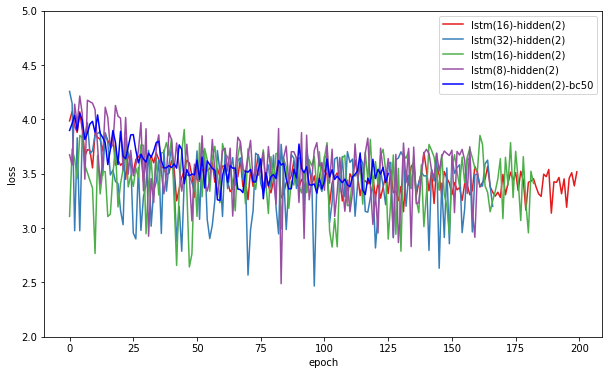

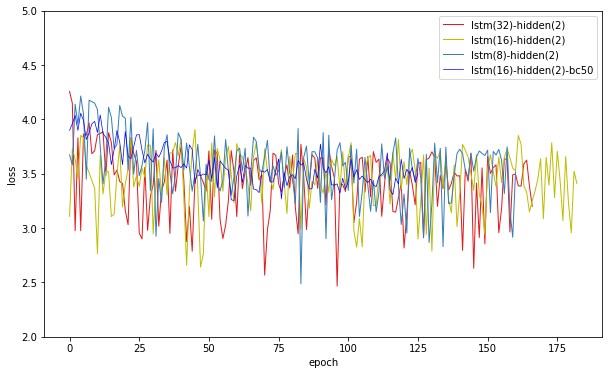

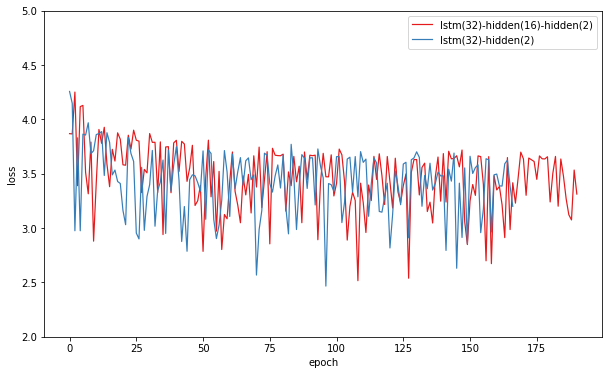

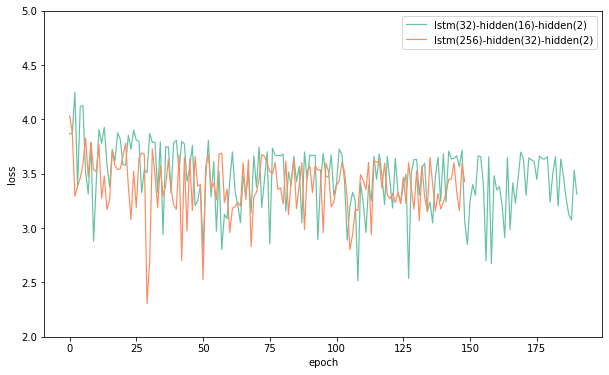

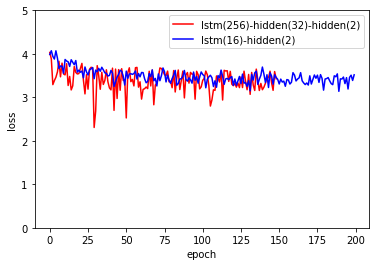

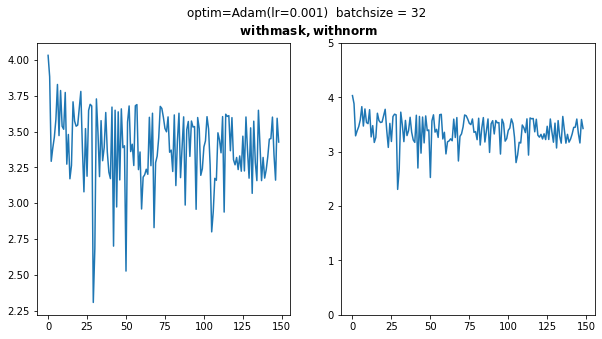

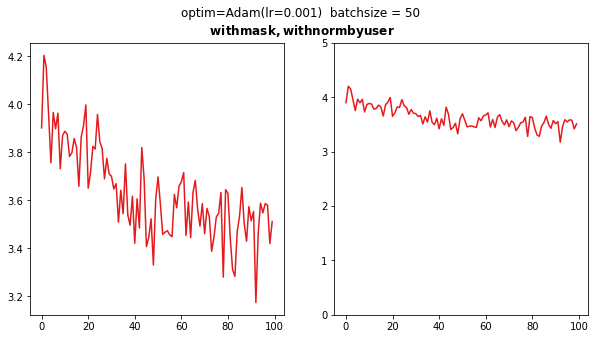

# Predict

In [ ]:
def
    batch_bar = tqdm(data_loader_valid, leave = True)
    predictions = []
    for batch_i, (feature_seqs, label_seqs, mask_seqs) in enumerate(batch_bar):
        seq_len = feature_seqs.shape[1]
        logits = model(feature_seqs) 

        label_flat = label_seqs.reshape(batch_size*seq_len, 1).tolist()
        output_flat = logits.reshape(batch_size*seq_len, num_class).tolist()
        index = int(mask_seqs.sum())
        pred = pd.DataFrame(output_flat[:index]).idxmax(axis=1).tolist()
        labels = pd.DataFrame(label_flat[:index]).idxmax(axis=1).tolist()
        predictions = predictions + pred
        break

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
pre, rec, f1, sup = precision_recall_fscore_support(labels, pred)

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, recall_score, precision_recall_curve, classification_report
import matplotlib.pyplot as plt

all_tags = {0: 0, 1: 1}
pre_batch_size = 1 ###
class Predictor():
    def __init__(self, model, raw_data):
              self.model = model
              self.raw_data = raw_data
              
    
    def predictor(self):
        """Return a list of part-of-speech tags as strings, one for each word.

        raw_data - a list of (word, tag) pairs.
        """

        with torch.no_grad(): # turns off automatic differentiation, which isn't required but helps save memory

            model.eval()
            loader = df_to_tensor(self.raw_data, batch_size = pre_batch_size, all_label = True, print_summary = False)

            predictions = []
            for batch in loader:
                feature_seqs, label_seqs, mask_seqs = batch

                seq_len = feature_seqs.shape[1]
                logits = self.model(feature_seqs) 
                output_distribution = logits.reshape(pre_batch_size*seq_len, num_class).tolist()

                
                index = int(mask_seqs.sum())

                pred = pd.DataFrame(output_distribution[:index]).idxmax(axis=1).tolist()
                predictions = predictions + pred

            model.train()
            return predictions

    def get_metrics(self):
        self.y_pred = self.predictor()
        self.yBin = self.raw_data['insider']
        report = classification_report(self.yBin, self.y_pred)
        print(report)

        # return report['True']

    # Compute ROC curve and ROC area for each class
    def acu_curve(self, y, y_prob):
        
        fpr, tpr, threshold = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, 
                tpr, 
                color = 'darkorange',
                lw = 2, 
                label = 'ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
        plt.xlim([0.0, 1.00])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc = "lower right")
        plt.show()

    def pr_curve(self, y, prob):

        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y, prob)

        #create precision recall curve
        plt.figure(figsize=(10, 10))
        plt.plot(recall, precision, color='purple')

        #add axis labels to plot
        plt.title('Precision-Recall Curve')
        plt.ylabel('Precision')
        plt.xlabel('Recall')

        #display plot
        plt.show()

In [ ]:
b = Predictor(model, data.test_df).predictor()

In [ ]:
"""data3.1 100 epochs"""
predictor = Predictor(model, data.train_df)
predictor.get_metrics()
predictor = Predictor(model, data.test_df)
predictor.get_metrics()

In [ ]:
"""data3.1 100 epochs"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0029
"""data3.1 100 epochs"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0028 ## SHUFFLED ##
"""data3.1_sf 100 epochs"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0027
"""data3.1 200 epochs"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0026 this should be the same exp as 18 ?!?!?!
"""data3.1"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0025
"""data2.1"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0024
"""redist_short_aug1_del1_norm_PCA"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0023
"""redist_aug1_del1_norm"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0022
"""redist_short_aug1_del1_norm"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0021
"""data3.4, four classes, with weight(not tuned)"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0020
"""no repeat, no PCA"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0019 
"""repeat 3 times, no PCA"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0018 
"""repeat 2 times, no PCA"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0017
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0016
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0016
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0014
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0013
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0012
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0011
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp0010
predictor = Predictor(model, df)
predictor.get_metrics()
comment

In [ ]:
# exp009
predictor = Predictor(model, df)
predictor.get_metrics()

In [ ]:
#exp008
model = torch.load('log/exp008/model_optim.pth')['model']
predictor = Predictor(model, pd.read_csv('data/data_2.1.csv', index_col='idx'))
predictor.get_metrics()

In [ ]:
# exp007
predictor = Predictor(model, df)
predictor.get_metrics()

In [ ]:
# pca, no weight loss, batchsize=50
predictor = Predictor(model, df)
predictor.get_metrics()

In [ ]:
# pca, deleted70, no weight loss, batchsize=32
predictor = Predictor(model, df)
predictor.get_metrics()

In [ ]:
# pca, weight loss 0.9,0.1
predictor = Predictor(model, df)
predictor.get_metrics()

In [ ]:
# pca, weight loss 0.1,0.9
predictor = Predictor(model, df)
predictor.get_metrics()
# accuracy so low

In [ ]:
# normall_lstm32_bc32_adam_nll
predictor = Predictor(model, df)
predictor.get_metrics()

In [ ]:
predictor = Predictor(model, df)
predictor.get_metrics()

1. Changed `predict_seqs = predict_seqs.reshape([batch_size,num_class,seq_len])`  
to `predict_seqs = predict_seqs.reshape([-1,num_class,seq_len])`

In [ ]:
#@title DataLoader

In [ ]:
%%writefile dataloader_.py

import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split

class MyData(Dataset): 
        def __init__(self, x, y):
            self.feature = x
            self.label = y
        def __len__(self): 
            return len(self.feature)
        def __getitem__(self, idx):
            return (self.feature[idx], self.label[idx])
            
# sequences by user: df to tensor
def df_to_tensor(df, batch_size, all_label, print_summary = False, shuffle = True):
    """
    Args:
        df (DataFrame): sequences(both feature and label) in a DataFrame.
                        must have column 'user'; the last column must be label.
        all_label (bool): output will be the labels of the whole sequence if True,
                          or the label of the last datapoint in the sequence otherwise.
        print_summary (bool, optional): print the size of output.
        shuffle (bool)
    """

    def collate_fn(feature_label): 

        # 第一维是batchsize，所以直接enumerate循环会循环20次
        # feature_label - List:[batchsize个Tuple:(2个Tensor:[maxlen, dimension])] batchsize*2*maxlen*dimension

        features, labels = [], [] # 时间复杂度？？？
        # labels = torch.zeros(len(feature_label), len(feature_label[1][0]))
        for unit in feature_label:
            features.append(unit[0])
            labels.append(unit[1])

        # pad features
        seqs_len = [sequence.size(0) for sequence in features]
        padded_f = pad_sequence(features, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起
        

        # pad labels
        seqs_len = [sequence.size(0) for sequence in labels]
        padded_l = pad_sequence(labels, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起

        # masks
        masks = [torch.ones(seq_len) for seq_len in seqs_len]
        padded_m = pad_sequence(masks, batch_first=True, padding_value=0)
        return (padded_f, padded_l, padded_m)

    from collections import defaultdict
    # dic of sequences in df format
    fea_df_dic = defaultdict(pd.DataFrame) # feature seq
    label_df = defaultdict(pd.DataFrame)# label seq
    for user in df.user.unique():
        fea_df_dic[user] = df[df.user == user].iloc[:, 1:-1]
        if all_label:
            # labels are the insider status of all activities in the sequence. [batchsize, maxlength (, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1]
        else:
            # label is the insider status of the last activity in the sequence. [batchsize (, 1, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1].iloc[[-1]]

    # list of features in tensor format (Need to be float32!)
    features = []
    for user, df_i in fea_df_dic.items():
        input_sub = torch.tensor(df_i.values).to(torch.float32)
        features.append(input_sub)
    # list of labels in tensor format (Need to be long!)
    labels = []
    for user, df_i in label_df.items():
        input_sub = torch.tensor(df_i.values).to(torch.long)
        labels.append(input_sub)

    # sequences tensors tuple to Dataset/DataLoader object
    data = MyData(features, labels)
    data_loader = DataLoader(data, batch_size, shuffle=shuffle, collate_fn=collate_fn) 

    if print_summary:
        print("==== DataFrame to DataLoader ====")
        print("Input DataFrame: {}".format(df.shape))
        print("   => {0} sequences ({0} users)".format(len(features)))
        print("       features in size of [(max) length, dimension] = {}".format(features[0].shape))
        print("       labels in size of [(max) length, dimension] = {}".format(labels[0].shape))
        print("   => output DataLoader: {} batches".format(len(data_loader)), "(batchsize = {})".format(batch_size))
        print("       features in size of [batchsize, (max) length, dimension] = {}".format(iter(data_loader).next()[0].shape))
        print("       labels in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[1].shape))
        print("       masks in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[2].shape))
    return data_loader